In [2]:
import os, sys
import pandas as pd
from datetime import datetime

from iwateruse.featurize import MultiOneHotEncoder
from iwateruse import data_cleaning, report, splittors, pre_train_utils, make_dataset, figures
from iwateruse import denoise, model_diagnose

import matplotlib.pyplot as plt
from xgboost import plot_importance
import xgboost as xgb

#
import numpy as np
from flopy.plot import styles

# sklearn
from sklearn.metrics import r2_score, mean_squared_error

# %%
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from pycaret.regression import *

import warnings

warnings.filterwarnings('ignore')
xgb.set_config(verbosity=0)

# %%
from iwateruse.model import Model
from iwateruse import targets, weights, pipelines, outliers_utils, estimators, featurize
from iwateruse import selection


# %%
# =============================
# Setup Training
# =============================
figures_folder = "figs"
model = Model(name='annual_pc', log_file = 'train_log.log',  feature_status_file= r"..\features_status.xlsx")
model.raw_target = 'wu_rate'
model.target = 'per_capita'

datafile = r"..\clean_train_db.csv" #clean_train_db_backup_6_24_2022.csv
df_train = pd.read_csv(datafile)
del(df_train['dom_frac'])
del(df_train['cii_frac'])
#df_train = df_train[['pop', 'wu_rate', 'dom_frac']]
model.add_training_df( df_train = df_train)

# make_dataset.make_ds_per_capita_basic(model, datafile=datafile)
# model.df_train['pop_density']  = model.df_train['pop']/model.df_train['WSA_SQKM']
# model.df_train.loc[model.df_train['WSA_SQKM']==0, 'pop_density'] = np.NaN
# add water use
seed1 = 123
seed2 = 456

# %%
model.apply_func(func=targets.compute_per_capita, type='target_func', args=None)

opts = ['pop<=100', 'per_capita>=500', 'per_capita<=25']
model.apply_func(func=outliers_utils.drop_values, type='outliers_func', opts = opts )
model.apply_func(func = outliers_utils.drop_na_target, type='outliers_func')

# =============================
# Feature Engineering
# =============================
# Target summary
tr_df, cat_df = featurize.summary_encode(model, cols=model.categorical_features)
df_concat = pd.concat([tr_df, cat_df], axis=1)
model.add_feature_to_skip_list( model.categorical_features)
model.add_training_df( df_train = df_concat)
del(tr_df); del(cat_df); del(df_concat)

# =============================
# Prepare the initial estimator
# =============================
params = {
    'objective': "reg:squarederror",
    'tree_method': 'hist',
    'colsample_bytree': 0.8,
    'learning_rate': 0.20,
    'max_depth': 7,
    'alpha': 100,
    'n_estimators': 500,
    'rate_drop': 0.9,
    'skip_drop': 0.5,
    'subsample': 0.8,
    'reg_lambda': 10,
    'min_child_weight': 50,
    'gamma': 10,
    'max_delta_step': 0,
    'seed': seed2
}
params2 = {
    'objective': "reg:squarederror",
    'tree_method': 'hist',
    'colsample_bytree': 0.5972129389586888,
    'learning_rate': 0.04371772054983907,
    'max_depth': 11,
    'alpha': 100,
    'n_estimators': 300,
    'subsample': 1,
    'reg_lambda': 1.2998981941716606e-08,
    'min_child_weight': 4,
    'gamma': 10,
    'max_delta_step': 0,
    'seed': seed2
}

gb = estimators.xgb_estimator(params2)

encode_cat_features = False
if encode_cat_features:
    # pipeline
    main_pipeline = pipelines.make_pipeline(model)
    main_pipeline.append(('estimator', gb))
    gb = Pipeline(main_pipeline)



# =============================
# Prepare the initial estimator
# =============================

features = model.features
target = model.target
final_dataset = model.df_train
ignore_features = list(set(final_dataset.columns).difference(set(features + [target])))



In [3]:
# =============================
# Prepare the initial estimator
# =============================

reg1 = setup(data = final_dataset, target = target, ignore_features = ignore_features,
             fold=5, fold_shuffle = True,
             train_size = 0.7)

# compare models
learning_algorithems = ['xgboost', 'rf', 'lightgbm', 'et'] # include = learning_algorithems
#best = compare_models(n_select = 5)





,Description,Value
0,session_id,2783
1,Target,per_capita
2,Original Data,"(74753, 156)"
3,Missing Values,True
4,Numeric Features,142
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(52327, 121)"


In [12]:
params = {
    'objective': "reg:squarederror",
    'tree_method': 'hist',
    'colsample_bytree': 0.8,
    'learning_rate': 0.20,
    'max_depth': 7,
    'alpha': 100,
    'n_estimators': 500,
    'rate_drop': 0.9,
    'skip_drop': 0.5,
    'subsample': 0.8,
    'reg_lambda': 10,
    'min_child_weight': 50,
    'gamma': 10,
    'max_delta_step': 0,
    'seed': 123
}
params_tuned = {'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 10,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.06740244695074946,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 11,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_estimators': 300,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2783,
 'reg_alpha': 1e-10,
 'reg_lambda': 1e-10,
 'sampling_method': 'uniform',
 'scale_pos_weight': 50.0,
 'subsample': 1.0,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': 0,
 'alpha': 100,
 'rate_drop': 0.9,
 'skip_drop': 0.5,
 'seed': 123}
xgb = create_model('xgboost', **params_tuned)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,27.4345,1929.9813,43.9316,0.7756,0.2822,0.2178
1,26.9650,1935.2014,43.9909,0.7721,0.2798,0.2138
2,27.4414,1989.6375,44.6054,0.7638,0.2862,0.2209
3,27.3231,1974.8258,44.4390,0.7657,0.2869,0.2217
4,27.9122,2073.5505,45.5363,0.7553,0.2893,0.2240
Mean,27.4152,1980.6393,44.5006,0.7665,0.2849,0.2196
Std,0.3031,51.7264,0.5781,0.0070,0.0034,0.0035


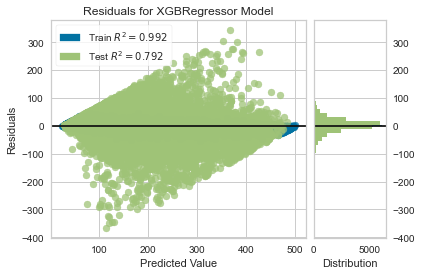

In [13]:
plot_model(xgb)

In [8]:
tuned_xgb= tune_model(xgb, fold = 5, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,27.4345,1929.9813,43.9316,0.7756,0.2822,0.2178
1,26.9650,1935.2014,43.9909,0.7721,0.2798,0.2138
2,27.4414,1989.6375,44.6054,0.7638,0.2862,0.2209
3,27.3231,1974.8258,44.4390,0.7657,0.2869,0.2217
4,27.9122,2073.5505,45.5363,0.7553,0.2893,0.2240
Mean,27.4152,1980.6393,44.5006,0.7665,0.2849,0.2196
Std,0.3031,51.7264,0.5781,0.0070,0.0034,0.0035


In [10]:
df_xgb = pd.DataFrame.from_dict(tuned_xgb.get_params(), orient = 'index')
df_xgb.to_csv("annual_xgb_tune.csv")
df_xgb

,0
objective,reg:squarederror
base_score,0.5
booster,gbtree
callbacks,None
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,0.5
early_stopping_rounds,None
enable_categorical,False
eval_metric,None


In [11]:
tuned_xgb.get_params()
"""
{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 10,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.06740244695074946,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 11,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 300,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2783,
 'reg_alpha': 1e-10,
 'reg_lambda': 1e-10,
 'sampling_method': 'uniform',
 'scale_pos_weight': 50.0,
 'subsample': 1.0,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': 0,
 'alpha': 100,
 'rate_drop': 0.9,
 'skip_drop': 0.5,
 'seed': 123}
"""

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 10,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.06740244695074946,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 11,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 300,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2783,
 'reg_alpha': 1e-10,
 'reg_lambda': 1e-10,
 'sampling_method': 'uniform',
 'scale_pos_weight': 50.0,
 'subsample': 1.0,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': 0,
 'alpha': 100,
 'rate_drop': 0.9,
 'skip_drop': 0.5,
 'seed': 123}

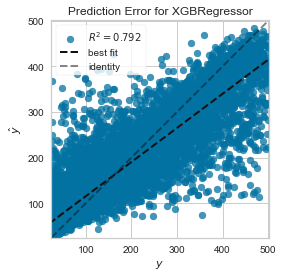

In [9]:
plot_model(tuned_xgb,  plot = 'error')

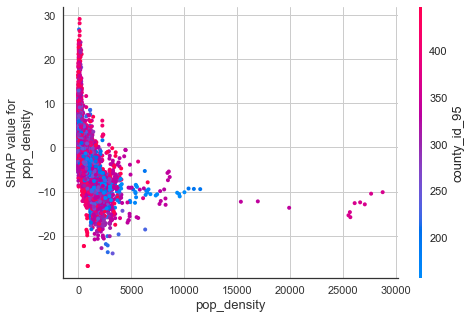

In [24]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'pop_density', cmap = None)

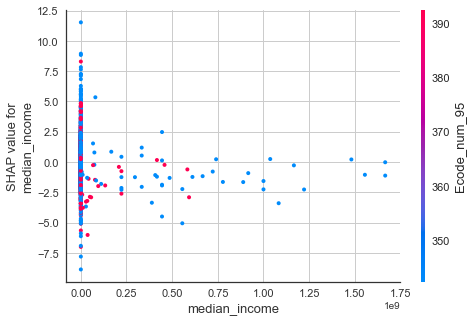

In [25]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'median_income', cmap = None)

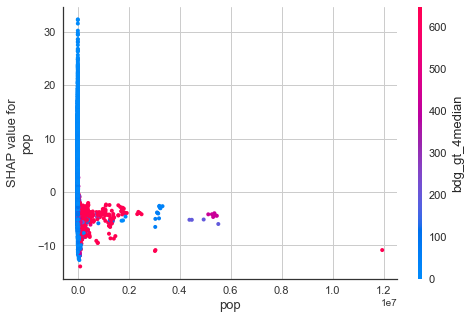

In [26]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'pop', cmap = None)

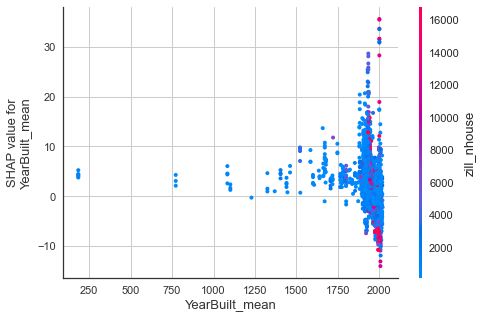

In [27]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'YearBuilt_mean', cmap = None)

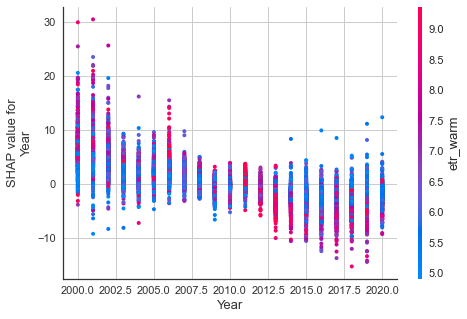

In [20]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'Year', cmap = None)

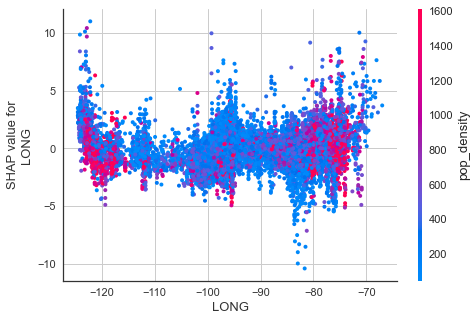

In [21]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'LONG', cmap = None)

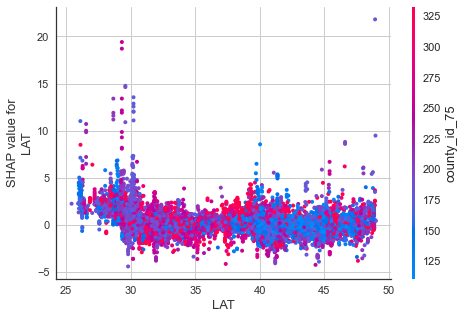

In [23]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'LAT', cmap = None)

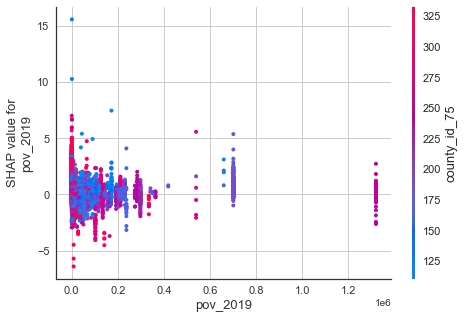

In [28]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'pov_2019', cmap = None)

# Light GBM

In [ ]:
lgb = create_model('lightgbm')
tuned_lgb= tune_model(lgb, fold = 3, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)# fit_params = {'objective': 'quantile', 'alpha':0.5}

In [ ]:
df_lgb = pd.DataFrame.from_dict(tuned_lgb.get_params(), orient = 'index')
df_lgb.to_csv("lgb_tune.csv")
df_lgb

In [ ]:
# tune et
et = create_model('et')
tuned_lgb= tune_model(et, fold = 3, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)